# Assignment: Coursera Capstone Project - The Battle of Neighborhoods
## Project: Compare boroughs from Lima and Toronto cities using the Foursquare location data
#### (Detailed explanation is included in the Capstone Project Report associated to this notebook)

In [1]:
# Import and install needed libraries
import pandas as pd
import numpy as np
import requests
import urllib
import re
import io

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# library to handle JSON files
import json 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics

! easy_install beautifulsoup4
from bs4 import BeautifulSoup          # scrape information from web pages

!conda install -c conda-forge folium=0.5.0
import folium                          # map rendering library

! conda install -c conda-forge geopy  
from geopy.geocoders import Nominatim  # convert an address into latitude and longitude values
from geopy.distance import geodesic    # calculate distance between two points

Searching for beautifulsoup4
Best match: beautifulsoup4 4.6.0
Adding beautifulsoup4 4.6.0 to easy-install.pth file

Using /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Processing dependencies for beautifulsoup4
Finished processing dependencies for beautifulsoup4
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-2.2.2               |           py35_1         462 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    ca-certificates-2019.3.9   |       hecc5

### Lima city data
#### Get data from web page and use Beautiful Soup to parse document

In [2]:
# scrape data from URL to get coordinates of districts of Lima
response = urllib.request.urlopen('https://www.antipodas.net/coordenadaspais/peru/lima.php#coordenadas')
html_doc = response.read()
soup = BeautifulSoup(html_doc, 'lxml')
tabla=soup.table.find_all('td')

# get table values
datos=[]
for i in tabla:
    datos.append(i.text.strip())
print(datos[0:9])

['Ciudad', 'Distancia', 'Coordenadas', 'Rimac', '2 Km', 'S12°1\'24.96" O77°1\'57.61"', 'Lima', '2 Km', 'S12°3\'3.92" O77°2\'56.04"']


#### Put scraped data in a dataframe

In [3]:
# put values in a dataframe
filas=[]
for i in range (0,len(datos),3):
    auxs=[]
    auxs.extend([datos[i],datos[i+1],datos[i+2]])
    filas.append(auxs)
cols=filas[0]
rows=filas[1:]

df_lim = pd.DataFrame(rows, columns=cols)
print('Shape: ' + str(df_lim.shape))

df_lim.columns = ['District','Distance','Coordinates']
df_lim.head()

Shape: (28, 3)


,District,Distance,Coordinates
0,Rimac,2 Km,"S12°1'24.96"" O77°1'57.61"""
1,Lima,2 Km,"S12°3'3.92"" O77°2'56.04"""
2,Breña,3 Km,"S12°3'32.98"" O77°3'2.12"""
3,La Victoria,3 Km,"S12°4'20.39"" O77°1'2.6"""
4,Jesús María,4 Km,"S12°4'39.36"" O77°2'48.08"""


#### Handle data to get Lima decimal coordinates

In [4]:
# rename District to Borough
df_lim = df_lim.rename(columns = {'District': 'Borough'})

# split coordinates in degrees into two columns
aux = df_lim['Coordinates'].str.split(' ', expand=True)
df_lim['Lat_Deg'] = aux[0]
df_lim['Lon_Deg'] = aux[1]

# convert coordinates in degrees to decimals
def dms2dd(s):
    # example: s = """0°51'56.29"S"""
    s=s[1:]+s[0]
    degrees, minutes, seconds, direction = re.split('[°\'"]+', s)
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction in ('S','O'):
        dd*= -1
    return dd

df_lim['Latitude'] = df_lim['Lat_Deg'].apply(dms2dd)
df_lim['Longitude'] = df_lim['Lon_Deg'].apply(dms2dd)

df_lim.head()

,Borough,Distance,Coordinates,Lat_Deg,Lon_Deg,Latitude,Longitude
0,Rimac,2 Km,"S12°1'24.96"" O77°1'57.61""","S12°1'24.96""","O77°1'57.61""",-12.023600,-77.032669
1,Lima,2 Km,"S12°3'3.92"" O77°2'56.04""","S12°3'3.92""","O77°2'56.04""",-12.051089,-77.048900
2,Breña,3 Km,"S12°3'32.98"" O77°3'2.12""","S12°3'32.98""","O77°3'2.12""",-12.059161,-77.050589
3,La Victoria,3 Km,"S12°4'20.39"" O77°1'2.6""","S12°4'20.39""","O77°1'2.6""",-12.072331,-77.017389
4,Jesús María,4 Km,"S12°4'39.36"" O77°2'48.08""","S12°4'39.36""","O77°2'48.08""",-12.077600,-77.046689


### Toronto city data
#### Get data from web page and use Beautiful Soup to parse document

In [5]:
# scrape data from URL to get coordinates of neighborhoods of Toronto
response = urllib.request.urlopen('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
html_doc = response.read()

soup = BeautifulSoup(html_doc, 'lxml')
tabla=soup.table.find_all('td')

# obtain table values
datos=[]
for i in tabla:
    datos.append(i.text.strip())

# put values in a dataframe
filas=[]
for i in range (0,len(datos),3):
    auxs=[]
    auxs.extend([datos[i],datos[i+1],datos[i+2]])
    filas.append(auxs)
cols=['Postcode','Borough','Neighbourhood']
rows=filas

df_can = pd.DataFrame(rows, columns=cols)

print('Shape: ' + str(df_can.shape))
df_can.head()

Shape: (288, 3)


,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


#### Organize Toronto data to remove useless values

In [6]:
# remove rows with a Borough that has a value of 'Not assigned'
df_can = df_can[df_can.Borough != 'Not assigned']
df_can = df_can.reset_index(drop=True)

# if a Neighbourhood is Not assigned, then the Neighbourhood value will be the same as the Borough
df_can['Neighbourhood'] = df_can.apply(lambda row: row['Borough'] if (row['Neighbourhood']=='Not assigned') else row['Neighbourhood'], axis=1)

# sort dataframe
df_can.sort_values('Postcode')

# combine Neighborhoods separated by comma
for i in range(0,len(df_can.index)-1): 
    if df_can.iloc[i][0] == df_can.iloc[i+1][0]:
        df_can.iloc[i+1][2] = df_can.iloc[i][2] + ', ' + df_can.iloc[i+1][2]

# select rows where the Neighborhood value length is the biggest
df_can = df_can.groupby(['Postcode','Borough'],as_index=False)['Neighbourhood'].max()

print('Shape: ' + str(df_can.shape))
df_can.head()

Shape: (103, 3)


,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


#### Handle data to get Toronto decimal coordinates

In [7]:
# get coordinates from Geospatial_data url
url = "http://cocl.us/Geospatial_data"
s = requests.get(url).content
coord = pd.read_csv(io.StringIO(s.decode('utf-8')))
coord.set_index('Postal Code', inplace=True)

# create new columns
df_tor = df_can
df_tor['Latitude'] = ''
df_tor['Longitude'] = ''

# lookup Postcode coordinates 
for i in range(0,len(df_tor)): 
    rowll = coord.loc[df_can['Postcode'][i]]
    df_can['Latitude'][i] = rowll[0]
    df_can['Longitude'][i] = rowll[1]
    
# check number of boroughs and neighborhoods
print('The dataframe has {} boroughs and {} neighborhoods.'.format(len(df_tor['Borough'].unique()), df_tor.shape[0]))
df_tor.head()

The dataframe has 11 boroughs and 103 neighborhoods.


,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.8067,-79.1944
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.7845,-79.1605
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.7636,-79.1887
3,M1G,Scarborough,Woburn,43.771,-79.2169
4,M1H,Scarborough,Cedarbrae,43.7731,-79.2395


### Map Lima and Toronto boroughs
#### Get coordinates for Lima and Toronto to center maps

In [8]:
# use geolocator to find coordinates
geolocator = Nominatim(user_agent="to_explorer")

# get geographical coordinates of Lima
address_lim = 'Lima, Peru'
location_lim = geolocator.geocode(address_lim)
lati_lim = location_lim.latitude
long_lim = location_lim.longitude
print('The geographical coordinates of Lima are {}, {}.'.format(lati_lim, long_lim))

# get geographical coordinates of Toronto
address_tor = 'Toronto, TO'
location_tor = geolocator.geocode(address_tor)
lati_tor = location_tor.latitude
long_tor = location_tor.longitude
print('The geographical coordinates of Toronto are {}, {}.'.format(lati_tor, long_tor))

The geographical coordinates of Lima are -12.0621065, -77.0365256.
The geographical coordinates of Toronto are 43.6523873, -79.3835641.


#### Create map for Lima and boroughs

In [9]:
# create map of Lima using latitude and longitude values
map_lim = folium.Map(location=[lati_lim, long_lim], control_scale=True, zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_lim['Latitude'], df_lim['Longitude'], df_lim['Borough']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lim)  
        
map_lim

#### Create map for Toronto and neighborhoods, and assign different colors to boroughs for better visualization

In [10]:
# create map of Toronto using latitude and longitude values
map_tor = folium.Map(location=[lati_tor, long_tor], control_scale=True, zoom_start=11)

bor_un=['']
bor_un=df_tor['Borough'].unique().tolist()
col_un=['']
col_un=['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightgreen', 'white', 'yellow', 'cadetblue', 'black']

def color_producer(stt):
    for i in range(0, len(bor_un)):
        if stt==bor_un[i]:
            return col_un[i]

# add markers to map
for lat, lng, clr, label in zip(df_tor['Latitude'], df_tor['Longitude'], df_tor['Borough'], df_tor['Neighbourhood']):    
    label = folium.Popup(clr+'-'+label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color_producer(clr),        
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor)  
    
map_tor

### Build dataset with main boroughs from Lima and Toronto
#### Selection of Toronto boroughs (will use boroughs instead of neighborhoods to compare similar locations with Lima)

In [11]:
# using geolocator I got strange coordinates for a couple of Boroughs in Toronto, so I used an average of coordinates instead
df_tor = df_tor.groupby('Borough', as_index=False)
df_tor = df_tor['Latitude','Longitude'].agg(np.average)       # average of coordinates from the neighborhoods of each borough

# select only boroughs sorrounding Downtown Toronto
tor_data = df_tor[df_tor['Borough'].isin(['Downtown Toronto','West Toronto','East Toronto','Central Toronto','York','East York'])]
tor_data = tor_data.reset_index(drop=True)

# create a dummy Postcode for easier visualization and reorder columns
tor_data['Postcode'] = tor_data.index
tor_data['Postcode'] = 'TOR'+tor_data['Postcode'].astype(str)
tor_data = tor_data[['Postcode','Borough','Latitude','Longitude']]

print('Toronto dataset has {} boroughs.'.format(len(tor_data['Borough'])))
tor_data.head()

Toronto dataset has 6 boroughs.


,Postcode,Borough,Latitude,Longitude
0,TOR0,Central Toronto,43.701980,-79.398954
1,TOR1,Downtown Toronto,43.654169,-79.383665
2,TOR2,East Toronto,43.669436,-79.324654
3,TOR3,East York,43.700303,-79.335851
4,TOR4,West Toronto,43.652653,-79.449290


#### Selection of Lima boroughs

In [12]:
# simplify Lima map and segment and cluster only main Districts of the city. 
lim_data = df_lim[df_lim['Borough'].isin(['Lima', 'Jesús María', 'San Luis', 'San Isidro', 'Magdalena Del Mar', 'San Borja', 'San Miguel', 'Miraflores', 'La Molina', 'Santiago De Surco', 'Barranco'])]
lim_data = lim_data.reset_index(drop=True)

# create a dummy Postcode for easier visualization and reorder columns
lim_data['Postcode'] = lim_data.index
lim_data['Postcode'] = 'LIM'+lim_data['Postcode'].astype(str)
lim_data = lim_data[['Postcode','Borough','Latitude','Longitude']]

print('Lima dataset has {} boroughs.'.format(len(lim_data['Borough'])))
lim_data.head()

Lima dataset has 11 boroughs.


,Postcode,Borough,Latitude,Longitude
0,LIM0,Lima,-12.051089,-77.048900
1,LIM1,Jesús María,-12.077600,-77.046689
2,LIM2,San Luis,-12.074089,-76.997239
3,LIM3,San Isidro,-12.098981,-77.036669
4,LIM4,Magdalena Del Mar,-12.093839,-77.066689


#### Merge selected boroughs from Lima and Toronto in a single dataframe

In [13]:
# merge Lima and Toronto dataframes
lim_tor_data = pd.concat([lim_data, tor_data])
lim_tor_data = lim_tor_data.reset_index(drop=True)
lim_tor_data

,Postcode,Borough,Latitude,Longitude
0,LIM0,Lima,-12.051089,-77.048900
1,LIM1,Jesús María,-12.077600,-77.046689
2,LIM2,San Luis,-12.074089,-76.997239
3,LIM3,San Isidro,-12.098981,-77.036669
4,LIM4,Magdalena Del Mar,-12.093839,-77.066689
5,LIM5,San Borja,-12.097550,-76.995211
6,LIM6,San Miguel,-12.076439,-77.090069
7,LIM7,Miraflores,-12.120911,-77.028931
8,LIM8,La Molina,-12.083331,-76.950000
9,LIM9,Santiago De Surco,-12.126989,-76.984381


#### Map merged boroughs from Lima and Toronto

In [14]:
# center map around Mexico
address_tmp = 'Ciudad de Mexico, Mexico'
location_tmp = geolocator.geocode(address_tmp)
lati_tmp = location_tmp.latitude
long_tmp = location_tmp.longitude

# create map of merged boroughs using latitude and longitude values
map_lim_tor = folium.Map(location=[lati_tmp, long_tmp], control_scale=True, zoom_start=3)

# add markers to map
for lat, lng, label in zip(lim_tor_data['Latitude'], lim_tor_data['Longitude'], lim_tor_data['Borough']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lim_tor)  
    
map_lim_tor

### Foursquare API location data
#### Set credentials

In [15]:
# utilize the Foursquare API to explore the neighborhoods and segment them
CLIENT_ID = 'N005T1SIJP035KQPCQFFU5ORVVTP5MX3GB4LI1N0GDFZJV0N' # Foursquare ID
CLIENT_SECRET = 'NIOCQL1LK4EELIJ32FL1OZEL1JTDCMMGZMYWNULKFEAJXMC4' # Foursquare Secret
VERSION = '20190101' # Foursquare API version

#### Determine the Radius parameter to be used when searching Foursquare

In [16]:
# function to get minimum distance from one borough to each other
def borough_distance(df_data):
    sumamin=0.0
    for i in range(0,len(df_data)):
        loc_fix=(df_data.iloc[i,2], df_data.iloc[i,3])
        mindist=1000.0
        dist=0.0
        for j in range(0,len(df_data)):
            loc_var=(df_data.iloc[j,2], df_data.iloc[j,3])
            if i!=j:
                dist=geodesic(loc_fix, loc_var).kilometers
                if dist<mindist:
                    mindist=dist
        sumamin=sumamin+mindist
    distminavg=sumamin/len(df_data)
    return (distminavg)

distancia_min=borough_distance(lim_data)
print('Average distance between boroughs in Lima: ' + str(distancia_min) + ' km')

distancia_min=borough_distance(tor_data)
print('Average distance between boroughs in Toronto: ' + str(distancia_min) + ' km')

Average distance between boroughs in Lima: 3.021975837914033 km
Average distance between boroughs in Toronto: 4.418396723355953 km


#### Define function to get venues from Foursquare

In [17]:
# use the get request function from Foursquare to extract the venue category of all boroughs. Foursquare has the information in the items key. 
def getNearbyVenues(zcodes, names, latitudes, longitudes, radius=1500):

    venues_list=[]
    for zcode, name, lat, lng in zip(zcodes, names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT) 
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            zcode, name, lat, lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                  'Borough Code', 'Borough', 'Borough Latitude', 'Borough Longitude', 
                  'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [18]:
# run the above function on each borough and create a new dataframe called lim_tor_venues. The number of venues is limited to 100 by location.
LIMIT = 100
lim_tor_venues = getNearbyVenues(zcodes=lim_tor_data['Postcode'],
                                 names=lim_tor_data['Borough'],
                                 latitudes=lim_tor_data['Latitude'],
                                 longitudes=lim_tor_data['Longitude'])

print(lim_tor_venues.shape)
lim_tor_venues.head()

(1462, 8)


,Borough Code,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,LIM0,Lima,-12.051089,-77.0489,Cremoladas Yayo,-12.052332,-77.055212,Dessert Shop
1,LIM0,Lima,-12.051089,-77.0489,Trattoria Italia,-12.046700,-77.045607,Italian Restaurant
2,LIM0,Lima,-12.051089,-77.0489,Estadio Teodoro Lolo Fernandez,-12.049415,-77.047480,Soccer Stadium
3,LIM0,Lima,-12.051089,-77.0489,"Dulcería ""Paquita""",-12.055150,-77.048910,Cupcake Shop
4,LIM0,Lima,-12.051089,-77.0489,El Chinito,-12.049279,-77.040837,Sandwich Place


In [19]:
# check how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(lim_tor_venues['Venue Category'].unique())))

# check how many venues were returned for each borough
lim_tor_venues.groupby('Borough').count()

There are 227 uniques categories.


,Borough Code,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,,
Barranco,100,100,100,100,100,100,100
Central Toronto,100,100,100,100,100,100,100
Downtown Toronto,100,100,100,100,100,100,100
East Toronto,100,100,100,100,100,100,100
East York,51,51,51,51,51,51,51
Jesús María,100,100,100,100,100,100,100
La Molina,88,88,88,88,88,88,88
Lima,44,44,44,44,44,44,44
Magdalena Del Mar,100,100,100,100,100,100,100


#### Analyze venue data using onehot encoding

In [20]:
# analyze each borough using onehot encoding
lim_tor_onehot = pd.get_dummies(lim_tor_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
lim_tor_onehot['Borough Code'] = lim_tor_venues['Borough Code'] 
lim_tor_onehot['Borough'] = lim_tor_venues['Borough'] 

# move borough columns to the first columns
fixed_columns = [lim_tor_onehot.columns[-2]]+ [lim_tor_onehot.columns[-1]] + list(lim_tor_onehot.columns[:-2])
lim_tor_onehot = lim_tor_onehot[fixed_columns]

print(lim_tor_onehot.shape)
lim_tor_onehot.head()

(1462, 229)


,Borough Code,Borough,Accessories Store,Afghan Restaurant,American Restaurant,Amphitheater,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,...,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,LIM0,Lima,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,LIM0,Lima,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,LIM0,Lima,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,LIM0,Lima,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,LIM0,Lima,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
lim_tor_grouped = lim_tor_onehot.groupby('Borough').mean().reset_index()

print(lim_tor_grouped.shape)
lim_tor_grouped

(17, 228)


,Borough,Accessories Store,Afghan Restaurant,American Restaurant,Amphitheater,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,...,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Barranco,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.010000,0.03,0.02,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.01,0.01,0.000000,0.000000
1,Central Toronto,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00,...,0.000000,0.00,0.010000,0.000000,0.010000,0.000000,0.01,0.01,0.000000,0.020000
2,Downtown Toronto,0.000000,0.000000,0.020000,0.00,0.00,0.00,0.000000,0.01,0.01,...,0.000000,0.01,0.030000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.010000
3,East Toronto,0.000000,0.000000,0.050000,0.00,0.01,0.00,0.000000,0.00,0.00,...,0.000000,0.00,0.000000,0.000000,0.010000,0.000000,0.00,0.00,0.000000,0.010000
4,East York,0.000000,0.039216,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00,...,0.039216,0.00,0.000000,0.000000,0.000000,0.019608,0.00,0.00,0.000000,0.019608
5,Jesús María,0.000000,0.000000,0.010000,0.00,0.00,0.00,0.000000,0.01,0.00,...,0.000000,0.00,0.010000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000
6,La Molina,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00,...,0.000000,0.00,0.022727,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000
7,Lima,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000
8,Magdalena Del Mar,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000
9,Miraflores,0.000000,0.000000,0.000000,0.00,0.00,0.01,0.000000,0.01,0.00,...,0.000000,0.00,0.020000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.010000


#### Create dataframe to visualize the 10 most common venues in each borough

In [22]:
# define a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# create the new dataframe and display the top 10 venues for each borough
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
boroughs_venues_sorted = pd.DataFrame(columns=columns)
boroughs_venues_sorted['Borough'] = lim_tor_grouped['Borough']

for ind in np.arange(lim_tor_grouped.shape[0]):
    boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(lim_tor_grouped.iloc[ind, :], num_top_venues)

print(boroughs_venues_sorted.shape)
boroughs_venues_sorted

(17, 11)


,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barranco,Bar,Peruvian Restaurant,Restaurant,Park,Seafood Restaurant,Café,Ice Cream Shop,Coffee Shop,Art Gallery,BBQ Joint
1,Central Toronto,Coffee Shop,Italian Restaurant,Café,Gym,Japanese Restaurant,Pizza Place,Gastropub,Sushi Restaurant,Deli / Bodega,Yoga Studio
2,Downtown Toronto,Café,Coffee Shop,Gastropub,Theater,Pizza Place,Ramen Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Cosmetics Shop,Thai Restaurant
3,East Toronto,Café,American Restaurant,Coffee Shop,Park,Brewery,Indian Restaurant,Italian Restaurant,Bakery,Bar,Burrito Place
4,East York,Indian Restaurant,Pharmacy,Sandwich Place,Coffee Shop,Restaurant,Pub,Turkish Restaurant,Pizza Place,Convenience Store,Afghan Restaurant
5,Jesús María,Seafood Restaurant,Peruvian Restaurant,Italian Restaurant,Coffee Shop,Bakery,Theater,Restaurant,Sushi Restaurant,Fried Chicken Joint,Ramen Restaurant
6,La Molina,Restaurant,Bakery,Seafood Restaurant,Breakfast Spot,Park,Supermarket,Athletics & Sports,Peruvian Restaurant,Dessert Shop,Coffee Shop
7,Lima,Bar,Seafood Restaurant,South American Restaurant,Hotel,Chinese Restaurant,Restaurant,Soccer Stadium,Farmers Market,Electronics Store,Pub
8,Magdalena Del Mar,Park,Italian Restaurant,Café,Restaurant,Peruvian Restaurant,Bakery,Seafood Restaurant,Burger Joint,Ice Cream Shop,Japanese Restaurant
9,Miraflores,Coffee Shop,Bar,Hotel,Restaurant,Café,Peruvian Restaurant,Seafood Restaurant,Sandwich Place,Ice Cream Shop,Bakery


### Cluster boroughs from Lima and Toronto
#### Prepare grouped data for clustering

In [23]:
# prepare data for clustering boroughs
lim_tor_grouped_clustering = lim_tor_grouped.drop('Borough', 1)
lim_tor_grouped_clustering.head()

,Accessories Store,Afghan Restaurant,American Restaurant,Amphitheater,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.000000,0.00,0.0,0.00,0.0,0.01,0.03,0.02,0.01,...,0.000000,0.00,0.00,0.0,0.00,0.000000,0.01,0.01,0.0,0.000000
1,0.0,0.000000,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.01,...,0.000000,0.00,0.01,0.0,0.01,0.000000,0.01,0.01,0.0,0.020000
2,0.0,0.000000,0.02,0.0,0.00,0.0,0.00,0.01,0.01,0.01,...,0.000000,0.01,0.03,0.0,0.00,0.000000,0.00,0.00,0.0,0.010000
3,0.0,0.000000,0.05,0.0,0.01,0.0,0.00,0.00,0.00,0.02,...,0.000000,0.00,0.00,0.0,0.01,0.000000,0.00,0.00,0.0,0.010000
4,0.0,0.039216,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,...,0.039216,0.00,0.00,0.0,0.00,0.019608,0.00,0.00,0.0,0.019608


#### Get optimal number of k clusters using the Elbow method

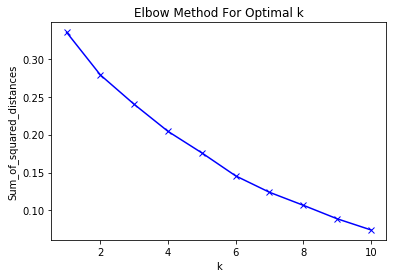

In [24]:
# apply Elbow method to determine best k clusters
sum_of_squared_distances=[]
score=[]
K=range(1,11)
for kclusters in K:
    kmeans = KMeans(n_clusters=kclusters, random_state=4)
    kmeans = kmeans.fit(lim_tor_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)
        
# Plot the elbow
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Run K-means algorithm with selected number of clusters (k=3)

In [25]:
# no clear elbow can be seen from the Elbow method, although there is a 'bigger' elbow in k=2;
# being k=2 a low number to cluster the boroughs, I chose k=3 to run the K-means algorithm for this assignment.

# set number of clusters
kclusters = 3
kmeans = KMeans(n_clusters=kclusters, random_state=4).fit(lim_tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 1, 1, 1, 1, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 1, 1], dtype=int32)

#### Create new dataframe that includes the cluster, merged with the top 10 venues for each borough

In [26]:
# add clustering labels from K-means algorithm
boroughs_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_)

# merge boroughs_venues_sorted with lim_tor_data to add latitude and longitude for each borough
lim_tor_merged = lim_tor_data.join(boroughs_venues_sorted.set_index('Borough'), on='Borough')
lim_tor_merged.head()

,Postcode,Borough,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,LIM0,Lima,-12.051089,-77.048900,0,Bar,Seafood Restaurant,South American Restaurant,Hotel,Chinese Restaurant,Restaurant,Soccer Stadium,Farmers Market,Electronics Store,Pub
1,LIM1,Jesús María,-12.077600,-77.046689,2,Seafood Restaurant,Peruvian Restaurant,Italian Restaurant,Coffee Shop,Bakery,Theater,Restaurant,Sushi Restaurant,Fried Chicken Joint,Ramen Restaurant
2,LIM2,San Luis,-12.074089,-76.997239,2,Seafood Restaurant,Restaurant,Fried Chicken Joint,Peruvian Restaurant,Pizza Place,Asian Restaurant,Burger Joint,Shopping Mall,Food,Food Truck
3,LIM3,San Isidro,-12.098981,-77.036669,0,Peruvian Restaurant,Hotel,Café,Restaurant,Italian Restaurant,Seafood Restaurant,Sushi Restaurant,Coffee Shop,Steakhouse,Japanese Restaurant
4,LIM4,Magdalena Del Mar,-12.093839,-77.066689,2,Park,Italian Restaurant,Café,Restaurant,Peruvian Restaurant,Bakery,Seafood Restaurant,Burger Joint,Ice Cream Shop,Japanese Restaurant


#### Visualize initial clustering in the map

In [27]:
# visualize the resulting clusters in the map (map centered around Mexico)
map_clusters = folium.Map(location=[lati_tmp, long_tmp], zoom_start=3)
rainbow = ['yellow','blue','green','red']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(lim_tor_merged['Latitude'], lim_tor_merged['Longitude'], lim_tor_merged['Borough'], lim_tor_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### The initial clustering can be analyzed looking at the boroughs that were grouped together below

In [28]:
lim_tor_merged.loc[lim_tor_merged['Cluster Label'] == 0, lim_tor_merged.columns[[0,1] + list(range(4, lim_tor_merged.shape[1]))]]

,Postcode,Borough,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,LIM0,Lima,0,Bar,Seafood Restaurant,South American Restaurant,Hotel,Chinese Restaurant,Restaurant,Soccer Stadium,Farmers Market,Electronics Store,Pub
3,LIM3,San Isidro,0,Peruvian Restaurant,Hotel,Café,Restaurant,Italian Restaurant,Seafood Restaurant,Sushi Restaurant,Coffee Shop,Steakhouse,Japanese Restaurant
7,LIM7,Miraflores,0,Coffee Shop,Bar,Hotel,Restaurant,Café,Peruvian Restaurant,Seafood Restaurant,Sandwich Place,Ice Cream Shop,Bakery
10,LIM10,Barranco,0,Bar,Peruvian Restaurant,Restaurant,Park,Seafood Restaurant,Café,Ice Cream Shop,Coffee Shop,Art Gallery,BBQ Joint


In [29]:
lim_tor_merged.loc[lim_tor_merged['Cluster Label'] == 1, lim_tor_merged.columns[[0,1] + list(range(4, lim_tor_merged.shape[1]))]]

,Postcode,Borough,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,TOR0,Central Toronto,1,Coffee Shop,Italian Restaurant,Café,Gym,Japanese Restaurant,Pizza Place,Gastropub,Sushi Restaurant,Deli / Bodega,Yoga Studio
12,TOR1,Downtown Toronto,1,Café,Coffee Shop,Gastropub,Theater,Pizza Place,Ramen Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Cosmetics Shop,Thai Restaurant
13,TOR2,East Toronto,1,Café,American Restaurant,Coffee Shop,Park,Brewery,Indian Restaurant,Italian Restaurant,Bakery,Bar,Burrito Place
14,TOR3,East York,1,Indian Restaurant,Pharmacy,Sandwich Place,Coffee Shop,Restaurant,Pub,Turkish Restaurant,Pizza Place,Convenience Store,Afghan Restaurant
15,TOR4,West Toronto,1,Coffee Shop,Café,Bar,Bakery,Sushi Restaurant,Park,Gastropub,Cocktail Bar,Pizza Place,Brewery
16,TOR5,York,1,Coffee Shop,Furniture / Home Store,Fast Food Restaurant,Park,Sandwich Place,Bakery,Grocery Store,Hardware Store,Café,Food & Drink Shop


In [30]:
lim_tor_merged.loc[lim_tor_merged['Cluster Label'] == 2, lim_tor_merged.columns[[0,1] + list(range(4, lim_tor_merged.shape[1]))]]

,Postcode,Borough,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,LIM1,Jesús María,2,Seafood Restaurant,Peruvian Restaurant,Italian Restaurant,Coffee Shop,Bakery,Theater,Restaurant,Sushi Restaurant,Fried Chicken Joint,Ramen Restaurant
2,LIM2,San Luis,2,Seafood Restaurant,Restaurant,Fried Chicken Joint,Peruvian Restaurant,Pizza Place,Asian Restaurant,Burger Joint,Shopping Mall,Food,Food Truck
4,LIM4,Magdalena Del Mar,2,Park,Italian Restaurant,Café,Restaurant,Peruvian Restaurant,Bakery,Seafood Restaurant,Burger Joint,Ice Cream Shop,Japanese Restaurant
5,LIM5,San Borja,2,Park,Chinese Restaurant,Coffee Shop,Seafood Restaurant,Shopping Mall,Gym,Fried Chicken Joint,Convenience Store,Dessert Shop,Theater
6,LIM6,San Miguel,2,Sandwich Place,Pizza Place,Seafood Restaurant,Café,Fried Chicken Joint,Park,Burger Joint,BBQ Joint,Peruvian Restaurant,Chinese Restaurant
8,LIM8,La Molina,2,Restaurant,Bakery,Seafood Restaurant,Breakfast Spot,Park,Supermarket,Athletics & Sports,Peruvian Restaurant,Dessert Shop,Coffee Shop
9,LIM9,Santiago De Surco,2,Park,Seafood Restaurant,Chinese Restaurant,Pizza Place,Bakery,Restaurant,Sandwich Place,Fast Food Restaurant,Coffee Shop,Fried Chicken Joint


In [31]:
lim_tor_merged.loc[lim_tor_merged['Cluster Label'] == 3, lim_tor_merged.columns[[0,1] + list(range(4, lim_tor_merged.shape[1]))]]

,Postcode,Borough,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


#### A pattern that can be seen from the previous dataframes is that boroughs from the same city are grouped together in the same cluster: 
#####     - boroughs from Lima are in Cluster 0 and 2;
#####     - boroughs from Toronto are in Cluster 1.
#### Another pattern is that the most common venues in all Clusters are Restaurants and Café / Coffee Shops.

#### Analyze most common venues by city

In [32]:
# analyze most common venues grouping by the 'Borough Code' prefix
comm_df = lim_tor_onehot.iloc[:,2:]
comm_df['City'] = lim_tor_onehot['Borough Code'].str[0:3]

# move City column to the first column
fixed_columns = [comm_df.columns[-1]] + list(comm_df.columns[:-1])
comm_df = comm_df[fixed_columns]

# add venues by city
comm_df = comm_df.groupby('City').sum()

# locations in Lima and Toronto sorted by the top 20 venue category
df_l = comm_df.iloc[0:1].sort_values(by=['LIM'], axis=1, ascending=False)
df_l = df_l.iloc[0:1,0:20]

df_t = comm_df.iloc[1:2].sort_values(by=['TOR'], axis=1, ascending=False)
df_t = df_t.iloc[0:1,0:20]

#### Plot most common venue categories in a bar chart

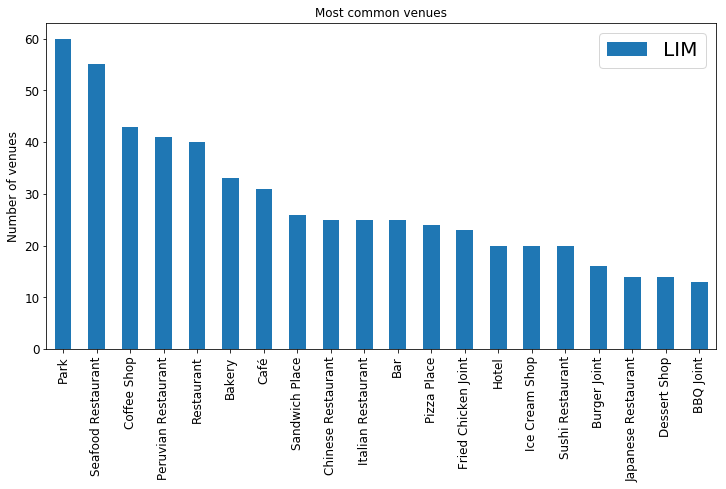

,Park,Seafood Restaurant,Coffee Shop,Peruvian Restaurant,Restaurant,Bakery,Café,Sandwich Place,Chinese Restaurant,Italian Restaurant,Bar,Pizza Place,Fried Chicken Joint,Hotel,Ice Cream Shop,Sushi Restaurant,Burger Joint,Japanese Restaurant,Dessert Shop,BBQ Joint
City,,,,,,,,,,,,,,,,,,,,
LIM,60,55,43,41,40,33,31,26,25,25,25,24,23,20,20,20,16,14,14,13


In [33]:
# bar chart most common venues in Lima
ax = df_l.transpose().plot(kind='bar', title ="Most common venues", figsize=(12, 6), legend=True, fontsize=12)
ax.legend(fontsize=20)
ax.set_ylabel("Number of venues", fontsize=12)
plt.show()
df_l

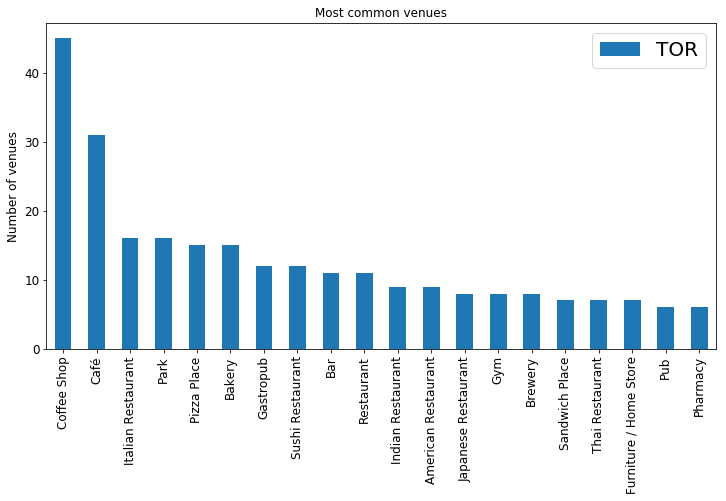

,Coffee Shop,Café,Italian Restaurant,Park,Pizza Place,Bakery,Gastropub,Sushi Restaurant,Bar,Restaurant,Indian Restaurant,American Restaurant,Japanese Restaurant,Gym,Brewery,Sandwich Place,Thai Restaurant,Furniture / Home Store,Pub,Pharmacy
City,,,,,,,,,,,,,,,,,,,,
TOR,45,31,16,16,15,15,12,12,11,11,9,9,8,8,8,7,7,7,6,6


In [34]:
# bar chart most common venues in Toronto
ax = df_t.transpose().plot(kind='bar', title ="Most common venues", figsize=(12, 6), legend=True, fontsize=12)
ax.legend(fontsize=20)
ax.set_ylabel("Number of venues", fontsize=12)
plt.show()
df_t

### Create a new dataset without Restaurants and Coffee venues
#### Remove all rows and columns associated to Restaurant and Café  / Coffee Shop venue categories

In [35]:
# create new dataframe without RESTAURANT and COFFEE venues
lim_tor_onehot_woRC = lim_tor_onehot

# remove all columns associated to Restaurants, Café and Coffee Shops
for col in lim_tor_onehot_woRC.columns:
    if col.find('Restaurant')!=-1 or col.find('Coffee')!=-1 or col.find('Café')!=-1:
        lim_tor_onehot_woRC = lim_tor_onehot_woRC.drop(col, axis=1)

for row in range(len(lim_tor_onehot_woRC.index)-1,0-1,-1):
    if lim_tor_onehot_woRC.iloc[row,2:].sum()==0:
        lim_tor_onehot_woRC = lim_tor_onehot_woRC.drop(row, axis=0)

lim_tor_grouped_woRC = lim_tor_onehot_woRC.groupby('Borough').mean().reset_index()

print('Shape' + str(lim_tor_grouped_woRC.shape))
lim_tor_grouped_woRC.head()

Shape(17, 179)


,Borough,Accessories Store,Amphitheater,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Athletics & Sports,...,Track Stadium,Trade School,Trail,University,Video Store,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Barranco,0.0,0.0,0.000000,0.0,0.045455,0.030303,0.015152,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.015152,0.015152,0.0,0.000000
1,Central Toronto,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.018519,0.0,0.000000,...,0.0,0.0,0.037037,0.000000,0.0,0.000000,0.018519,0.018519,0.0,0.037037
2,Downtown Toronto,0.0,0.0,0.000000,0.0,0.017544,0.017544,0.017544,0.0,0.000000,...,0.0,0.0,0.000000,0.017544,0.0,0.000000,0.000000,0.000000,0.0,0.017544
3,East Toronto,0.0,0.0,0.017544,0.0,0.000000,0.000000,0.035088,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.017544
4,East York,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.029412,...,0.0,0.0,0.000000,0.000000,0.0,0.029412,0.000000,0.000000,0.0,0.029412


#### Create dataframe to visualize the 10 most common venues in each borough (without Restaurant and Coffee venues)

In [36]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
boroughs_venues_sorted_woRC = pd.DataFrame(columns=columns)
boroughs_venues_sorted_woRC['Borough'] = lim_tor_grouped_woRC['Borough']

for ind in np.arange(lim_tor_grouped_woRC.shape[0]):
    boroughs_venues_sorted_woRC.iloc[ind, 1:] = return_most_common_venues(lim_tor_grouped_woRC.iloc[ind, :], num_top_venues)

print(boroughs_venues_sorted_woRC.shape)
boroughs_venues_sorted_woRC.head()

(17, 11)


,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barranco,Bar,Park,Ice Cream Shop,Art Gallery,Pizza Place,Brewery,Hotel,Steakhouse,Bakery,Nightclub
1,Central Toronto,Gym,Gastropub,Pizza Place,Deli / Bodega,Yoga Studio,Bakery,Dessert Shop,Park,Bookstore,Pharmacy
2,Downtown Toronto,Theater,Gastropub,Cosmetics Shop,Hotel,Pizza Place,Gym,Concert Hall,Movie Theater,Plaza,Burrito Place
3,East Toronto,Park,Brewery,Bar,Bakery,Burger Joint,Burrito Place,Pizza Place,Pet Store,Beach,Diner
4,East York,Pharmacy,Sandwich Place,Pub,Convenience Store,Pizza Place,Supermarket,Burger Joint,Cheese Shop,Bridge,Skating Rink


#### Apply K-means algorithm to final dataset

In [37]:
# prepare data for clustering boroughs
lim_tor_grouped_clustering_woRC = lim_tor_grouped_woRC.drop('Borough', 1)

# set number of clusters and run k-means algorithm
kclusters = 3
kmeans = KMeans(n_clusters=kclusters, random_state=4).fit(lim_tor_grouped_clustering_woRC)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_)

[0 2 2 0 2 2 2 0 2 0 1 0 2 2 1 0 2]


#### Create new dataframe that includes the cluster, merged with the top 10 venues for each borough (without Restaurant and Coffee venues)

In [38]:
# add clustering labels from K-means algorithm
boroughs_venues_sorted_woRC.insert(0, 'Cluster Label', kmeans.labels_)

# merge boroughs_venues_sorted with lim_tor_data to add latitude/longitude for each borough
lim_tor_merged_woRC = lim_tor_data.join(boroughs_venues_sorted_woRC.set_index('Borough'), on='Borough')
lim_tor_merged_woRC

,Postcode,Borough,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,LIM0,Lima,-12.051089,-77.048900,0,Bar,Hotel,Pharmacy,Department Store,Sports Bar,Beer Bar,Plaza,Dessert Shop,Bookstore,Supermarket
1,LIM1,Jesús María,-12.077600,-77.046689,2,Bakery,Theater,BBQ Joint,Fried Chicken Joint,Snack Place,Park,Movie Theater,Deli / Bodega,Sandwich Place,Convenience Store
2,LIM2,San Luis,-12.074089,-76.997239,2,Fried Chicken Joint,Farmers Market,Food,Park,Bakery,BBQ Joint,Shopping Mall,Food Truck,Burger Joint,Pizza Place
3,LIM3,San Isidro,-12.098981,-77.036669,0,Hotel,Steakhouse,Bar,Bistro,Park,Art Gallery,Pizza Place,Bakery,Yoga Studio,Gym
4,LIM4,Magdalena Del Mar,-12.093839,-77.066689,2,Park,Bakery,Burger Joint,Ice Cream Shop,Fried Chicken Joint,Cupcake Shop,Theater,Sandwich Place,Beach,Pizza Place
5,LIM5,San Borja,-12.097550,-76.995211,1,Park,Shopping Mall,Dessert Shop,Gym,Convenience Store,Fried Chicken Joint,Candy Store,Pastry Shop,Bakery,Theater
6,LIM6,San Miguel,-12.076439,-77.090069,2,Sandwich Place,Pizza Place,Fried Chicken Joint,Park,Burger Joint,BBQ Joint,Shopping Mall,Gym,Ice Cream Shop,Gym / Fitness Center
7,LIM7,Miraflores,-12.120911,-77.028931,0,Hotel,Bar,Bakery,Sandwich Place,Ice Cream Shop,Cocktail Bar,Gym,Plaza,Pizza Place,Gym / Fitness Center
8,LIM8,La Molina,-12.083331,-76.950000,2,Bakery,Park,Athletics & Sports,Supermarket,Breakfast Spot,Dessert Shop,Steakhouse,Sandwich Place,Shopping Mall,Donut Shop
9,LIM9,Santiago De Surco,-12.126989,-76.984381,1,Park,Pizza Place,Sandwich Place,Bakery,Burger Joint,Gym / Fitness Center,Fried Chicken Joint,Spa,Pool,Dessert Shop


#### Visualize final clustering in the map

In [39]:
# visualize the resulting clusters in the map
map_clusters = folium.Map(location=[lati_tmp, long_tmp], zoom_start=3, control_scale = True)
rainbow = ['yellow','blue','green','red']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(lim_tor_merged_woRC['Latitude'], lim_tor_merged_woRC['Longitude'], lim_tor_merged_woRC['Borough'], lim_tor_merged_woRC['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### The final clustering can be analyzed looking at the boroughs that were grouped together below

In [40]:
lim_tor_merged_woRC.loc[lim_tor_merged_woRC['Cluster Label'] == 0, lim_tor_merged_woRC.columns[[0,1] + list(range(4, lim_tor_merged_woRC.shape[1]))]]

,Postcode,Borough,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,LIM0,Lima,0,Bar,Hotel,Pharmacy,Department Store,Sports Bar,Beer Bar,Plaza,Dessert Shop,Bookstore,Supermarket
3,LIM3,San Isidro,0,Hotel,Steakhouse,Bar,Bistro,Park,Art Gallery,Pizza Place,Bakery,Yoga Studio,Gym
7,LIM7,Miraflores,0,Hotel,Bar,Bakery,Sandwich Place,Ice Cream Shop,Cocktail Bar,Gym,Plaza,Pizza Place,Gym / Fitness Center
10,LIM10,Barranco,0,Bar,Park,Ice Cream Shop,Art Gallery,Pizza Place,Brewery,Hotel,Steakhouse,Bakery,Nightclub
13,TOR2,East Toronto,0,Park,Brewery,Bar,Bakery,Burger Joint,Burrito Place,Pizza Place,Pet Store,Beach,Diner
15,TOR4,West Toronto,0,Bakery,Bar,Park,Pizza Place,Brewery,Cocktail Bar,Gastropub,Dog Run,Beer Bar,Snack Place


In [41]:
lim_tor_merged_woRC.loc[lim_tor_merged_woRC['Cluster Label'] == 1, lim_tor_merged_woRC.columns[[0,1] + list(range(4, lim_tor_merged_woRC.shape[1]))]]

,Postcode,Borough,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,LIM5,San Borja,1,Park,Shopping Mall,Dessert Shop,Gym,Convenience Store,Fried Chicken Joint,Candy Store,Pastry Shop,Bakery,Theater
9,LIM9,Santiago De Surco,1,Park,Pizza Place,Sandwich Place,Bakery,Burger Joint,Gym / Fitness Center,Fried Chicken Joint,Spa,Pool,Dessert Shop


In [42]:
lim_tor_merged_woRC.loc[lim_tor_merged_woRC['Cluster Label'] == 2, lim_tor_merged_woRC.columns[[0,1] + list(range(4, lim_tor_merged_woRC.shape[1]))]]

,Postcode,Borough,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,LIM1,Jesús María,2,Bakery,Theater,BBQ Joint,Fried Chicken Joint,Snack Place,Park,Movie Theater,Deli / Bodega,Sandwich Place,Convenience Store
2,LIM2,San Luis,2,Fried Chicken Joint,Farmers Market,Food,Park,Bakery,BBQ Joint,Shopping Mall,Food Truck,Burger Joint,Pizza Place
4,LIM4,Magdalena Del Mar,2,Park,Bakery,Burger Joint,Ice Cream Shop,Fried Chicken Joint,Cupcake Shop,Theater,Sandwich Place,Beach,Pizza Place
6,LIM6,San Miguel,2,Sandwich Place,Pizza Place,Fried Chicken Joint,Park,Burger Joint,BBQ Joint,Shopping Mall,Gym,Ice Cream Shop,Gym / Fitness Center
8,LIM8,La Molina,2,Bakery,Park,Athletics & Sports,Supermarket,Breakfast Spot,Dessert Shop,Steakhouse,Sandwich Place,Shopping Mall,Donut Shop
11,TOR0,Central Toronto,2,Gym,Gastropub,Pizza Place,Deli / Bodega,Yoga Studio,Bakery,Dessert Shop,Park,Bookstore,Pharmacy
12,TOR1,Downtown Toronto,2,Theater,Gastropub,Cosmetics Shop,Hotel,Pizza Place,Gym,Concert Hall,Movie Theater,Plaza,Burrito Place
14,TOR3,East York,2,Pharmacy,Sandwich Place,Pub,Convenience Store,Pizza Place,Supermarket,Burger Joint,Cheese Shop,Bridge,Skating Rink
16,TOR5,York,2,Furniture / Home Store,Sandwich Place,Park,Hardware Store,Grocery Store,Bakery,Food & Drink Shop,Pharmacy,Pizza Place,Department Store


In [43]:
lim_tor_merged_woRC.loc[lim_tor_merged_woRC['Cluster Label'] == 3, lim_tor_merged_woRC.columns[[0,1] + list(range(4, lim_tor_merged_woRC.shape[1]))]]

,Postcode,Borough,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


#### Excluding Restaurant and Coffee venue categories, Cluster 0 and 2 consists now of mixed boroughs from Lima and Toronto.
#### (Detailed explanation is included in the Capstone Project Report associated to this notebook)

### End of coding !!